In [2]:
import numpy as np
import pandas as pd
import random
import pathlib
import matplotlib.pyplot as plt
from astropy.table import Table
data_dir = pathlib.Path('/gscratch/astro/mmckay18/DATA/')

In [4]:
manga_catalogue_path = data_dir / 'raw'/ 'SDSS17Pipe3D_v3_1_1.fits'
dat = Table.read(manga_catalogue_path, format='fits', hdu=1)
cat_df = dat.to_pandas()
cat_df['PLATEIFU'] = cat_df['plateifu'].apply(lambda x: x.decode())
cat_df['IFUSIZE'] = cat_df['PLATEIFU'].map(lambda x: x.split('-')[-1][:-2])

### Add BPT classification

In [8]:
from fits_utils import BPT_diagnostic
suffix = 'cen' # ratio within central 2.5 arcsec aperture

OIII_key = f'log_OIII_Hb_{suffix}'
NII_key = f'log_NII_Ha_{suffix}'
tmp_SF, tmp_AGN = BPT_diagnostic(cat_df[NII_key])

cat_df['BPT_flag'] = np.nan
cat_df.loc[cat_df[OIII_key] < tmp_SF,'BPT_flag'] = 1
cat_df.loc[(cat_df[OIII_key] >= tmp_SF) & (cat_df['log_OIII_Hb_cen'] < tmp_AGN),'BPT_flag'] = 2
cat_df.loc[(cat_df[OIII_key] >= tmp_AGN),'BPT_flag'] = 3
cat_df.loc[(cat_df[OIII_key] > 1.5),'BPT_flag'] = np.nan
cat_df.loc[(cat_df[OIII_key] < -1.5),'BPT_flag'] = np.nan
cat_df.loc[(cat_df[NII_key] > 1.0),'BPT_flag'] = np.nan
cat_df.loc[(cat_df[NII_key] < -1.5),'BPT_flag'] = np.nan

# Sample dataset from larger catalogue  
`/qfs/projects/gumby/data/manga/splits/{SPLIT_DIR}/{split}_fits.csv`

In [9]:
split_dir = 'OH_2'

# using galaxies that are within 1st and 99th percentile in each of these properties
cols_of_interest = ['EW_Ha_cen']
condition_list = [((cat_df[key] > cat_df[key].quantile(0.05)) & (cat_df[key] < cat_df[key].quantile(0.95)))for key in cols_of_interest]

# make cuts on SFR, Av, stellar mass, central metallicity, IFU size, inclination
condition_list += [(cat_df['BPT_flag'] == 1)]
condition_list += [(cat_df['log_SFR_Ha'] > 0.0)]
condition_list += [(cat_df['log_Mass'] >= 10.0)]
condition_list += [(cat_df['log_Mass'] <= 11.0)]
#condition_list += [(cat_df['OH_Pet04_O3N2_Re_fit'] <= 8.8)]
condition_list += [(cat_df['Av_gas_Re'] < 2.0)]
#condition_list += [(cat_df['IFUSIZE'] == '127') | (cat_df['IFUSIZE'] == '91') | (cat_df['IFUSIZE'] == '61')]
condition_list += [(cat_df['nsa_inclination'] <= 45.0)]
inds = np.logical_and.reduce(condition_list)

# make dataframe of galaxies
df = cat_df[inds].copy()
df.reset_index(inplace=True)
print(len(cat_df), len(df))
print(df['IFUSIZE'].value_counts())

10220 438
127    169
61      94
37      89
91      62
19      24
Name: IFUSIZE, dtype: int64


In [10]:
cols_to_keep = cols_of_interest + ['PLATEIFU','nsa_redshift']
cols_to_bin = ['log_NII_Ha_cen']

for this_key in cols_to_bin:
    q=3
    labels = [f'{this_key}_{i}' for i in range(q)]
    df[f'{this_key}_bins'] = pd.qcut(df[this_key], q=q, labels=labels)

# want a similar number of IFU sizes in each split
group_by_cols = [f'{this_key}_bins' for this_key in cols_to_bin] + ['IFUSIZE']
grouper = df.groupby(by=group_by_cols)
list_of_dicts = []
min_gals = 8
max_gals = 100

for group, grouped_df in grouper:
    ngals = len(grouped_df)
    if ngals > max_gals:
        tmp_df = grouped_df.sample(n=max_gals)
        print(f'Sampling N={max_gals} from group')
    elif ngals < min_gals:
        print(f'Group too small ({ngals})' )
        continue
    else:
        print(f'Splitting {ngals} into train/val/test')
        tmp_df = grouped_df
    
    ginds = tmp_df.index.tolist()
    random.shuffle(ginds)
    n_train = int(ngals*0.85)
    n_val = max(1,int(ngals*0.07))

    train_inds = ginds[0:n_train]
    val_inds = ginds[n_train:n_train+n_val]
    test_inds = ginds[n_train+n_val:n_train+n_val+n_val]
    
    for i in ginds:
        if i in train_inds:
            this_dict = {'split':'train'}
            this_dict.update(df.iloc[i][cols_to_keep].to_dict())
            list_of_dicts.append(this_dict)
        elif i in val_inds:
            this_dict = {'split':'val'}
            this_dict.update(df.iloc[i][cols_to_keep].to_dict())
            list_of_dicts.append(this_dict)
        elif i in test_inds:
            this_dict = {'split':'test'}
            this_dict.update(df.iloc[i][cols_to_keep].to_dict())
            list_of_dicts.append(this_dict)

new_df = pd.DataFrame(list_of_dicts)
print(f"N={len(new_df[new_df.split == 'test'])}  / {len(new_df[new_df.split == 'val'])} / {len(new_df[new_df.split == 'train'])}", f"({len(new_df[new_df.split == 'val'])*1.0/len(new_df):.3})")

Splitting 71 into train/val/test
Group too small (2)
Splitting 26 into train/val/test
Splitting 27 into train/val/test
Splitting 20 into train/val/test
Splitting 50 into train/val/test
Splitting 13 into train/val/test
Splitting 29 into train/val/test
Splitting 31 into train/val/test
Splitting 23 into train/val/test
Splitting 48 into train/val/test
Splitting 9 into train/val/test
Splitting 34 into train/val/test
Splitting 36 into train/val/test
Splitting 19 into train/val/test
N=25  / 25 / 364 (0.0604)


### Save to CSVs

In [11]:
split_list = ['train', 'val', 'test']
new_df['fits_file'] = new_df['PLATEIFU'].map(lambda x: data_dir / 'raw' / x.split('-')[0] / x.split('-')[1] / f'manga-{x}-LOGCUBE-SPX-MILESHC-MASTARSSP.fits.gz')

outdir = data_dir / 'splits' / split_dir
print(outdir)
if not outdir.exists():
    outdir.mkdir(parents=True, exist_ok=True)
    print(f'created {outdir}')

for split in split_list:
    inds = new_df['split'] == split
    print(f'{split.title()}: {len(new_df[inds])}')
    output_csv = outdir / f'{split}_fits.csv'
    new_df[inds]['fits_file'].to_csv(output_csv, index=False,header=False)


/gscratch/astro/mmckay18/DATA/splits/OH_2
created /gscratch/astro/mmckay18/DATA/splits/OH_2
Train: 364
Val: 25
Test: 25


### Physical properties of galaxies in split_dir CSVs

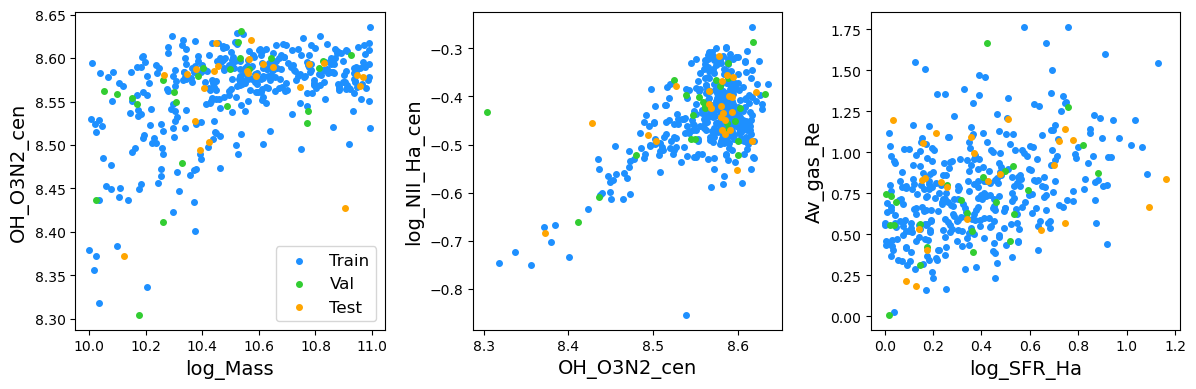

In [12]:
split_dir = 'OH_2'

csv_dir = data_dir / 'splits' / split_dir
file_list_dict = {
    'train': csv_dir / 'train_fits.csv',
    'val': csv_dir / 'val_fits.csv',
    'test': csv_dir / 'test_fits.csv',
}

cols_of_interest = ['OH_O3N2_cen','EW_Ha_cen','log_SFR_Ha','log_Mass','Av_gas_Re','log_NII_Ha_cen']

fig,axes = plt.subplots(1,3,figsize=(12,4))
colors = ['DodgerBlue','limegreen','orange']
name_pairs = [('log_Mass','OH_O3N2_cen'), ('OH_O3N2_cen','log_NII_Ha_cen'), ('log_SFR_Ha','Av_gas_Re')]

for i, (split_name, csv_path) in enumerate(file_list_dict.items()):

    file_list = pd.read_csv(csv_path, names=['fits_file'])['fits_file'].map(lambda x: '-'.join(x.split('/')[-3:-1])).tolist()

    # find matching rows
    inds = cat_df['PLATEIFU'].map(lambda x: x in file_list)

    # plot
    for ax_i in range(len(name_pairs)):
        x_col, y_col = name_pairs[ax_i]
        fig.axes[ax_i].scatter(cat_df[inds][x_col],cat_df[inds][y_col], s=16, c=colors[i], label=split_name.title())

for ax_i in range(len(name_pairs)):
    x_col, y_col = name_pairs[ax_i]
    fig.axes[ax_i].set_xlabel(x_col, size=14)
    fig.axes[ax_i].set_ylabel(y_col, size=14)
    if ax_i == 0:
        fig.axes[ax_i].legend(fontsize=12)
plt.tight_layout()

# Visualize Label Maps

In [22]:
from utils import get_label_path
import matplotlib as mpl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib

from utils import get_OH_bins_and_labels, get_index_to_name
from vis_fns import create_OH_map
data_dir = pathlib.Path('/gscratch/scrubbed/mmckay18/DATA/')

split_dir = 'BPT'
label_task='BPT'
OH_key='extra'
split = 'test'
num_to_sample=20

csv_dir = data_dir / 'splits' / split_dir
file_list_dict = {
    'train': csv_dir / f'train_fits.csv',
    'val': csv_dir / f'val_fits.csv',
    'test': csv_dir / f'test_fits.csv',
}

list_of_fits_files = pd.read_csv(file_list_dict[split], header=None, names=['fits_file'])['fits_file'].to_list()
print(len(list_of_fits_files))

index_to_name = get_index_to_name(OH_key, log=True)


num_classes=len(index_to_name)
cname='viridis'
cmap = mpl.cm.__getattribute__(cname)
bounds = np.arange(0, num_classes+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
sM = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

fits_files = np.random.choice(list_of_fits_files,size=num_to_sample,replace=False)
for fits_file in fits_files:
    label_file = get_label_path(fits_file, label_task=label_task)
    
    if pathlib.Path(label_file).exists():
        # make label map from values
        map_mask = create_OH_map(label_file, OH_key=OH_key)

        this_label = label_file.split('/')[-1].strip('.npy')

        fig,ax = plt.subplots(figsize=(4,4))
        ax.imshow(map_mask, cmap=cname, norm=norm, origin='lower')
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)

        cbar = fig.colorbar(
            sM,
            ticks=bounds,
            boundaries=bounds,
            ax=ax,
        )
        cbar.set_ticks([i+0.5 for i in range(num_classes)])
        cbar.set_ticklabels([index_to_name[i] for i in range(num_classes)])
        cbar.set_label(f'log( O / H )')
        ax.set_title(this_label,size=14)
    else:
        print('Does Not Exist')

25
Does Not Exist
Does Not Exist
Does Not Exist
Does Not Exist
Does Not Exist
Does Not Exist
Does Not Exist
Does Not Exist
Does Not Exist
Does Not Exist
Does Not Exist
Does Not Exist
Does Not Exist
Does Not Exist
Does Not Exist
Does Not Exist
Does Not Exist
Does Not Exist
Does Not Exist
Does Not Exist


# Patches: label statistics

In [1]:
from utils import get_index_to_name
from vis_fns import bin_OH_labels
import pandas as pd
import numpy as np
import pathlib
import matplotlib.pyplot as plt
data_dir = pathlib.Path('/gscratch/scrubbed/mmckay18/DATA/')


patch_norm='global'
split_dir = 'BPT'
easy_splits = True
OH_key='extra'
OH_log=False

split_str = '_easy' if easy_splits else ''
csv_dir = data_dir / 'splits' / split_dir
split_dict = {
    'train':csv_dir / f'train-{patch_norm}{split_str}.csv',
    'val':csv_dir / f'val-{patch_norm}{split_str}.csv',
    'test':csv_dir / f'test-{patch_norm}{split_str}.csv'
}

FileNotFoundError: [Errno 2] No such file or directory: '/gscratch/astro/mmckay18/DATA/splits/OH_2/train-global.csv'

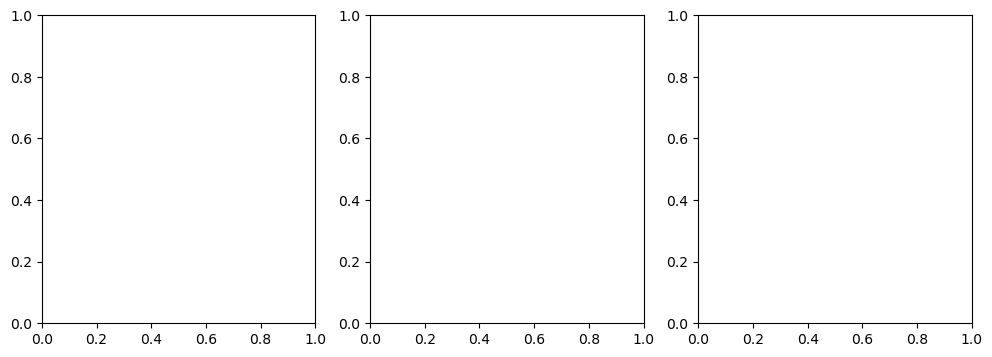

In [16]:
fig, axes = plt.subplots(1,len(split_dict.keys()), figsize=(12,4))

label_map = get_index_to_name(OH_key, log=OH_log)
fixed_label_order = [v for k,v in label_map.items()]

for i, (split_name, csv_path) in enumerate(split_dict.items()):
    df = pd.read_csv(csv_path)
    df['label'] = bin_OH_labels(df['label'], OH_key=OH_key)
    ax = fig.axes[i]
    df['label'].map(label_map).value_counts()[fixed_label_order].plot(kind='bar', ax=ax, rot=45, fontsize=12)
    ax.set_title(f'{split_name.title()} ({len(df):.1e} patches)', fontsize=18)
    ax.set_xlabel('log( O / H )')
fig.tight_layout()

In [42]:
split_name='train'
csv_path = split_dict[split_name]
df = pd.read_csv(csv_path)
intervals = pd.qcut(df.label, 8)

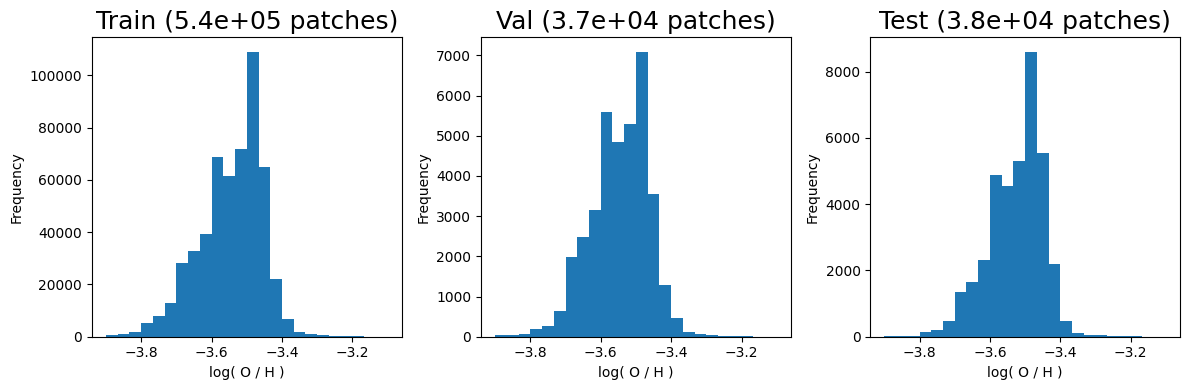

In [10]:
fig, axes = plt.subplots(1,len(split_dict.keys()), figsize=(12,4))
bins = np.linspace(8.1,8.9,25) - 12.0
for i, (split_name, csv_path) in enumerate(split_dict.items()):
    df = pd.read_csv(csv_path)
    df['label'] = df.label.map(float) - 12.0
    ax = fig.axes[i]
    df['label'].plot(kind='hist', ax=ax, bins=bins)
    ax.set_title(f'{split_name.title()} ({len(df):.1e} patches)', fontsize=18)
    ax.set_xlabel('log( O / H )')
fig.tight_layout()